In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
trip_start_date = '2018-07-01'                                               # selected trip start and end dates
trip_end_date = '2018-07-11'

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [8]:
Base.classes.keys()

['measurement', 'station']

In [9]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
session = Session(engine)

In [11]:
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

prcp_data_df = pd.DataFrame(prcp_data)
prcp_data_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


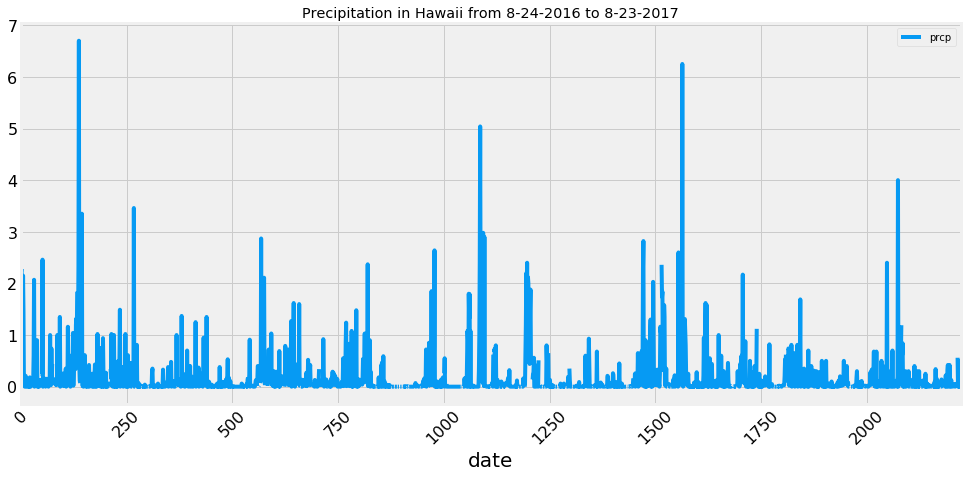

In [12]:
prcp_data_df.plot(figsize=(15, 7),                                              # plots the data
               sort_columns=True, 
               rot=45, 
               use_index=True, 
               title='Precipitation in Hawaii from 8-24-2016 to 8-23-2017', 
               legend=True,
               fontsize=16,
               grid=True,
               color='xkcd:azure'
              )

plt.xlabel('date', fontsize=20)
plt.show()

In [13]:
prcp_data_df.describe()                                                 

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
station_count = session.query(Station.id).count()                            # counts number of stations
print(f'There are {station_count} weather stations in Hawaii.')

There are 9 weather stations in Hawaii.


In [15]:
station_activity = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

In [16]:
station_activity    

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [17]:
station_activity[0]

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

In [18]:
for row in reversed(station_activity):                                       
    most_active_station=row.station
    most_active_name=str(row.name)
    most_active_station_tobs = session.query(Measurement.tobs).\
filter(Measurement.station == most_active_station, Measurement.station == Station.station,\
       Measurement.date >=" 2016-08-246", Measurement.date <="2017-08-23").all()

In [19]:
temperatures = [temp[0] for temp in most_active_station_tobs]

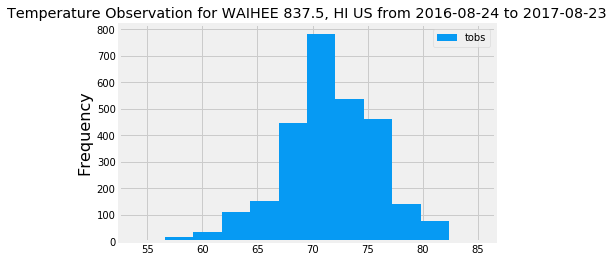

In [20]:
plt.hist(temperatures, bins=12, color='xkcd:azure')                          
plt.title("Temperature Observation for %s from 2016-08-24 to 2017-08-23" % (most_active_name))
plt.ylabel('Frequency', fontsize=16)
labels = ['tobs']
plt.legend(labels)
plt.show()

In [21]:
def calc_temps(start, end):
    """ function calc_temps
        parameters: start (string), end (string)
        returns: list
        extracts data using a SQL Alchemy query and returns list
        of avg temperature, lowest temperature, highest temperature
    """
    temp_list = []
    query = session.query(Measurement.tobs).filter(Measurement.date>=start, Measurement.date<=end).all()
    temperatures = [temp[0] for temp in query]
    temp_list.append(np.mean(temperatures))
    temp_list.append(min(temperatures))
    temp_list.append(max(temperatures))
    
    return temp_list

In [22]:
def get_prev_year_date(target):
    """ function get_prev_year_date
        parameters: target (string)
        returns: string
        disassembles string and subtracts 1 from year portion
        returns parameter input on error
    """
    try:
        xl = target.split('-')
        xc = (str(int(xl[0])-1)) + '-' + xl[1] + '-' + xl[2]
        return xc
    except:
        return target

In [23]:
start_conv = get_prev_year_date(trip_start_date)                             
end_conv = get_prev_year_date(trip_end_date)

In [24]:
temp_list = calc_temps(start_conv, end_conv)

In [25]:
temp_list  

[78.03030303030303, 69.0, 87.0]

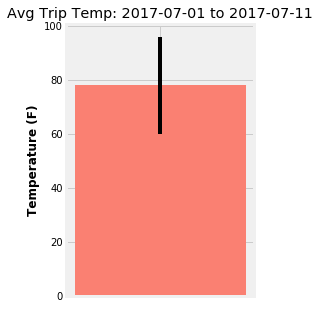

In [26]:
plt.figure(figsize=(3,5))                                                    # plots data
plt.bar(1, temp_list[0], yerr=(temp_list[2] - temp_list[1]), tick_label='', color='salmon')
plt.ylabel("Temperature (F)", weight="bold")
plt.title("Avg Trip Temp: %s to %s" % (start_conv, end_conv))
plt.show()

In [27]:
station_rainfall = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp).label('precipitation')).\
filter(Measurement.station == Station.station, Measurement.date >= start_conv, Measurement.date <= end_conv).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

In [28]:
rainfall_df = pd.DataFrame(station_rainfall)  

In [29]:
rainfall_df = rainfall_df.set_index('station')                               
del rainfall_df['name']  

In [30]:
rainfall_df  

,precipitation
station,
USC00516128,1.36
USC00519281,0.79
USC00513117,0.41
USC00519397,0.12
USC00514830,0.06
USC00519523,0.02
USC00517948,NaN


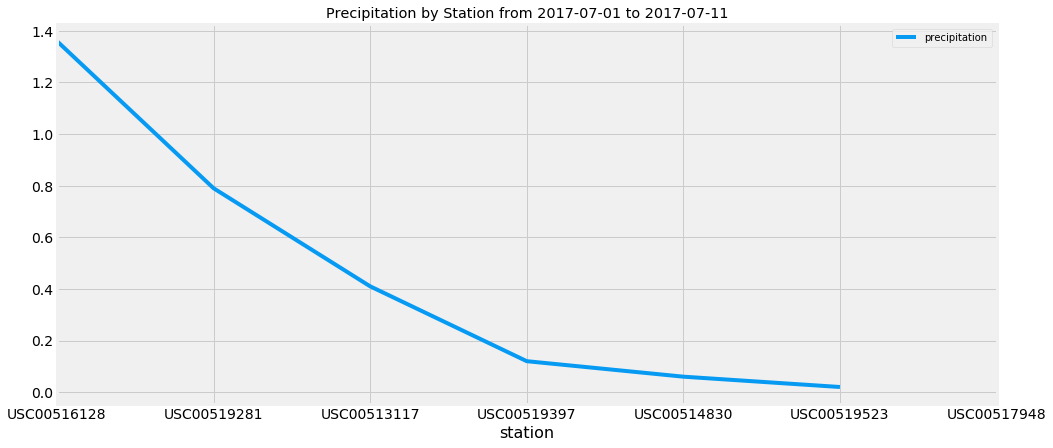

In [32]:
rainfall_df.plot(figsize=(15, 7),                                           
               sort_columns=True, 
               use_index=True, 
               title='Precipitation by Station from %s to %s' % (start_conv, end_conv), 
               legend=True,
               fontsize=14,
               grid=True,
               color='xkcd:azure'
              )

plt.xlabel('station', fontsize=16)
plt.show()

In [33]:
def get_pdate(target):
    """ function get_pdate 
        parameters: target (string)
        returns: string
        splits input string in date format and returns
        partial date in %m-%d format.
    """
    target_parse = target.split('-')
    return target_parse[1] + '-' + target_parse[2]

In [34]:
def daily_normals(target_date):
    """ function daily_normals
        parameters: target_date (string)
        returns: list
        extracts data using a SQL Alchemy query and returns list
        of averages of min, avg, and max temperature.
    """
    temp_list = []
    query = session.query(Measurement.tobs).filter(Measurement.date.like('%' + get_pdate(target_date))).all()
    temperatures = [temp[0] for temp in query]
    temp_list.append(target_date)
    temp_list.append(min(temperatures))
    temp_list.append(np.mean(temperatures))
    temp_list.append(max(temperatures))
    
    return temp_list

In [37]:
def get_date_list(start_date, end_date):
    """ function get_date_list
        parameters: start_date (string), end_date (string)
        returns: list
        extracts all dates between start_date and end_date
        and returns dates in %Y-%m-%d format.
    """
    date_list = []
    
    tsds = start_date.split('-')
    teds = end_date.split('-')
    
    begin = dt.date(int(tsds[0]), int(tsds[1]), int(tsds[2]))
    end = dt.date(int(teds[0]), int(teds[1]), int(teds[2]))

    next_day = begin
    while True:
        if next_day > end:
            break
        date_list.append(str(next_day))
        next_day += dt.timedelta(days=1)
    
    return date_list

In [38]:
target_date_list = get_date_list(start_conv, end_conv)

In [39]:
data_list = []                                                              
for item in target_date_list:
    data_list.append(daily_normals(item))

In [40]:
daily_normals_df = pd.DataFrame(data_list, columns=['date','tmin', 'tavg', 'tmax'])
daily_normals_df = daily_normals_df.set_index('date') 

In [41]:
daily_normals_df 

,tmin,tavg,tmax
date,,,
2017-07-01,67.0,74.777778,81.0
2017-07-02,68.0,75.403846,82.0
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0
2017-07-06,69.0,75.000000,81.0
2017-07-07,69.0,74.910714,82.0
2017-07-08,69.0,76.083333,83.0
2017-07-09,68.0,76.192982,83.0


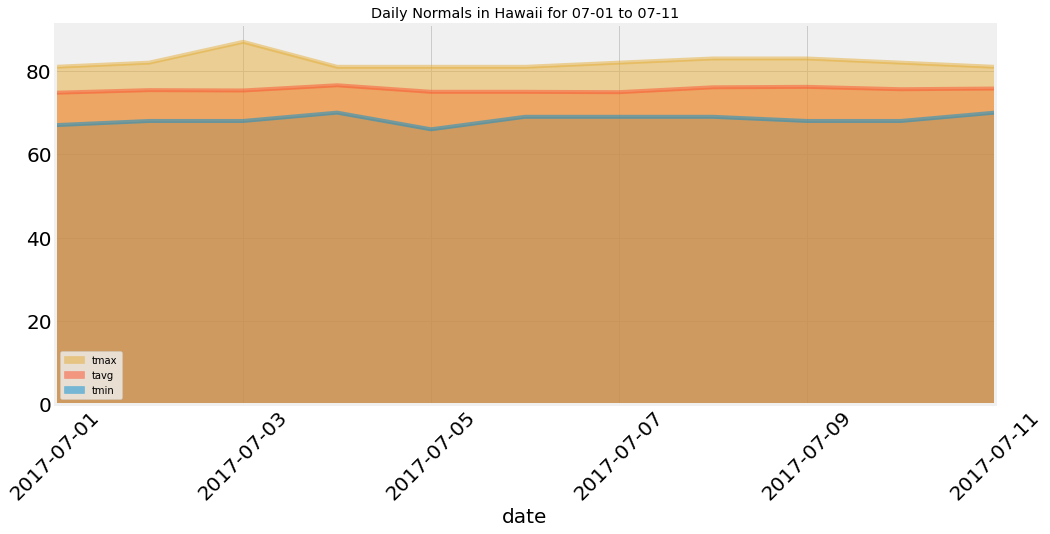

In [42]:
daily_normals_df.plot(figsize=(15, 7),                                      
                      kind='area',
                      sort_columns=True, 
                      rot=45, 
                      use_index=True, 
                      title='Daily Normals in Hawaii for %s to %s' % (get_pdate(start_conv), get_pdate(end_conv)), 
                      stacked=False,
                      legend='reverse',
                      fontsize=20,
                      grid=True,
                     ) 

plt.xlabel('date', fontsize=20)
plt.show()